In [1]:
%config InlineBackend.figure_format = "retina"

import numpy as np
from spamm.run_spamm import spamm
from spamm.components.EmissionComponent import EmissionComponent
from spamm.analysis import plot_best_models, plot_chains
from spamm.Samples import Samples
from spamm.Spectrum import Spectrum
import corner
import matplotlib.pyplot as plt

### Generating Mock Emission Line Data

In this section, we'll demonstrate how to generate a synthetic spectrum with emission lines and then running SPAMM on it. We will utilize the built-in logic of SPAMM itself to create some mock data of emission lines.

1. **Instantiating the Mock Spectrum**: Using the `MockSpectrum` class, we create a mock spectrum object that will be the foundation for generating our synthetic data.

2. **Defining Emission Line Parameters**: We then specify parameters for the emission lines, including their amplitudes, locations (wavelengths), and widths. These parameters will determine the characteristics of the emission lines in the spectrum.

3. **Generating Emission Line Flux**: With the parameters defined, we use the `EmissionComponent` class to generate the emission line flux. This involves calculating the flux contribution of each emission line based on the specified parameters.

4. **Adding a Power-law Continuum**: To make the spectrum more realistic, we generate a power-law continuum, which simulates the underlying spectral energy distribution. This continuum will be combined with the emission line flux.

5. **Adding Noise**: To simulate observational data more accurately, we introduce a small amount of noise into the synthetic spectrum. This noise is typically a percentage of the total flux.

6. **Plotting the Spectrum**: Finally, we plot the combined spectrum, showing the mock emission lines superimposed on the power-law continuum. This visual representation helps us to inspect the synthetic data and verify that the emission lines and continuum have been correctly combined.


In [2]:
def powerlaw(x, x0, amp, alpha):
    return amp * (x/x0)**alpha

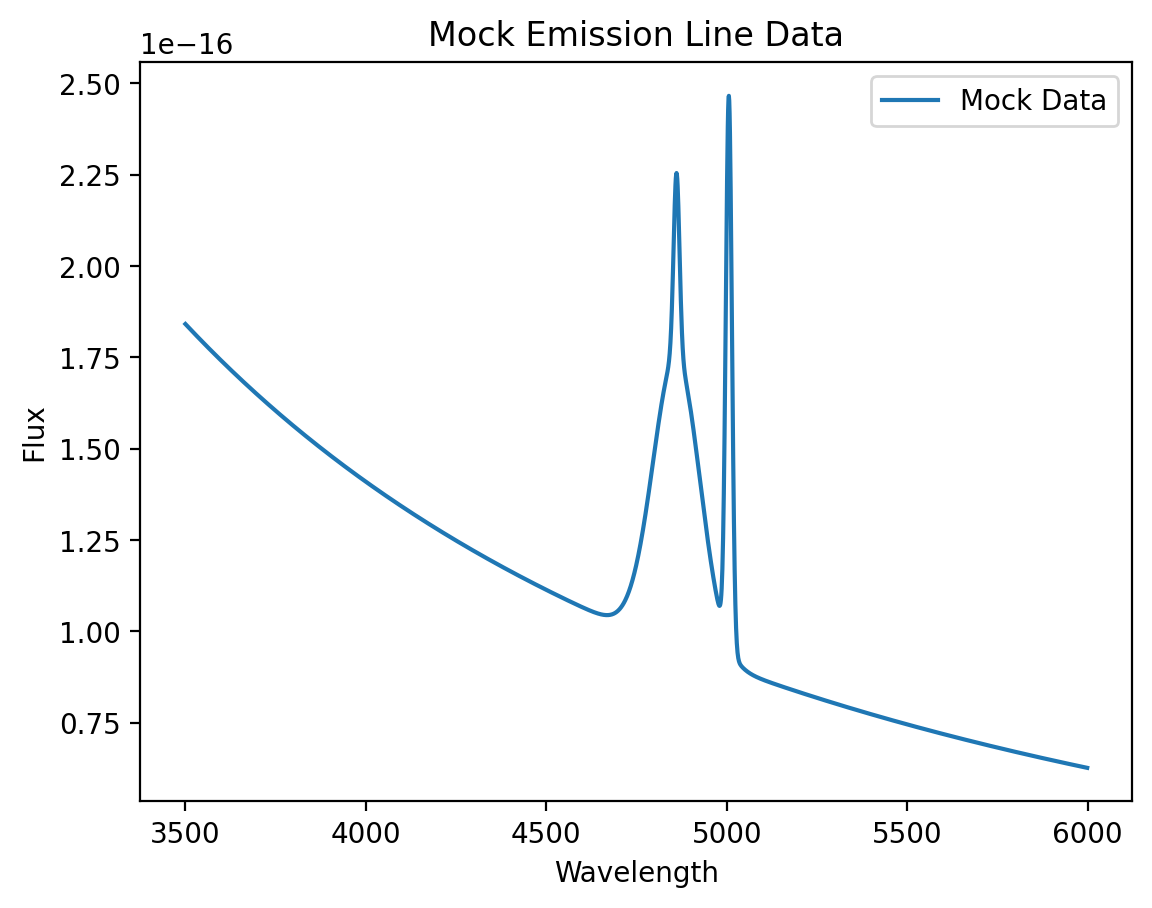

In [3]:
# Create a spectral axis (wavelength range)
wave = np.arange(3500., 6000., 1)

# Instantiate the MockSpectrum
#mock_spectrum = MockSpectrum(wave)

mock_spectrum = Spectrum(spectral_axis=wave, flux=np.zeros_like(wave), flux_error=np.zeros_like(wave))

# Create some emission line values
EL_PARAMS = {'narrow_width': 500,
             'Hbeta_4861_amp_0': 5e-17,
             'Hbeta_4861_loc_0': 4861,
             'Hbeta_4861_amp_1': 8e-17,
             'Hbeta_4861_loc_1': 4861,
             'Hbeta_4861_width_1': 4000,
             '[OIII]_5006_amp_0': 15e-17,
             '[OIII]_5006_loc_0': 5006}

# Instantiate EmissionComponent
emission_component = EmissionComponent()

# Generate emission line model flux using the SPAMM engine
el_flux = emission_component.flux(mock_spectrum, EL_PARAMS)

# Generate powerlaw model flux
amp = 1e-16
slope = -2.0
wave0 = np.median(wave)

pl_flux = powerlaw(x=wave, x0=wave0, amp=amp, alpha=slope)

# Add the emission line flux to the powerlaw flux
flux = el_flux + pl_flux

# Make the noise 2% of the flux
noise = flux * 0.02

# Plot the combined mock flux data
plt.plot(wave, flux, label='Mock Data')
plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Mock Emission Line Data')
plt.show()

## Configuring Emission Lines

To customize the emission line components in your model, you need to edit the `emission_lines.json` file located in the working directory. In this file, you can specify the following for each emission line:

- **Name**: The identifier for the emission line.
- **Laboratory Wavelength**: The rest-frame wavelength of the emission line.
- **Line Type**: Specify whether the line is narrow or broad.
- **Gaussian Components (for Broad Lines)**: If the line is broad, specify the number of Gaussian components to include.

**Important:** Broad emission lines automatically include a narrow component whose width is linked to all other narrow components in the model. For example, if you specify 3 Gaussian components for a broad line, the model will include 4 components in total: 1 narrow and 3 broad.

To modify the prior ranges for the Gaussian components, you will need to edit the `parameters.yaml` configuration file. This allows you to adjust the priors for each component, tailoring the model to your specific requirements.


In [4]:
spamm_out = spamm(complist=['EL', 'PL'], inspectrum=(wave, flux, noise),
                  n_walkers=50, n_iterations=5000, parallel=False,
                  outdir="emission_example", picklefile="emission_example");

100%|██████████████████████████████████████| 5000/5000 [00:37<00:00, 133.22it/s]


[SPAMM]: Mean acceptance fraction: 0.371
[SPAMM]: Saved pickle file: emission_example/emission_example.pickle.gz
[SPAMM]: Execution time: 38.285 seconds


In [5]:
S = Samples("emission_example/emission_example.pickle.gz", outdir='emission_example', burn=3000)
plot_best_models(S)

[SPAMM]: Saved emission_example_bestfits.png


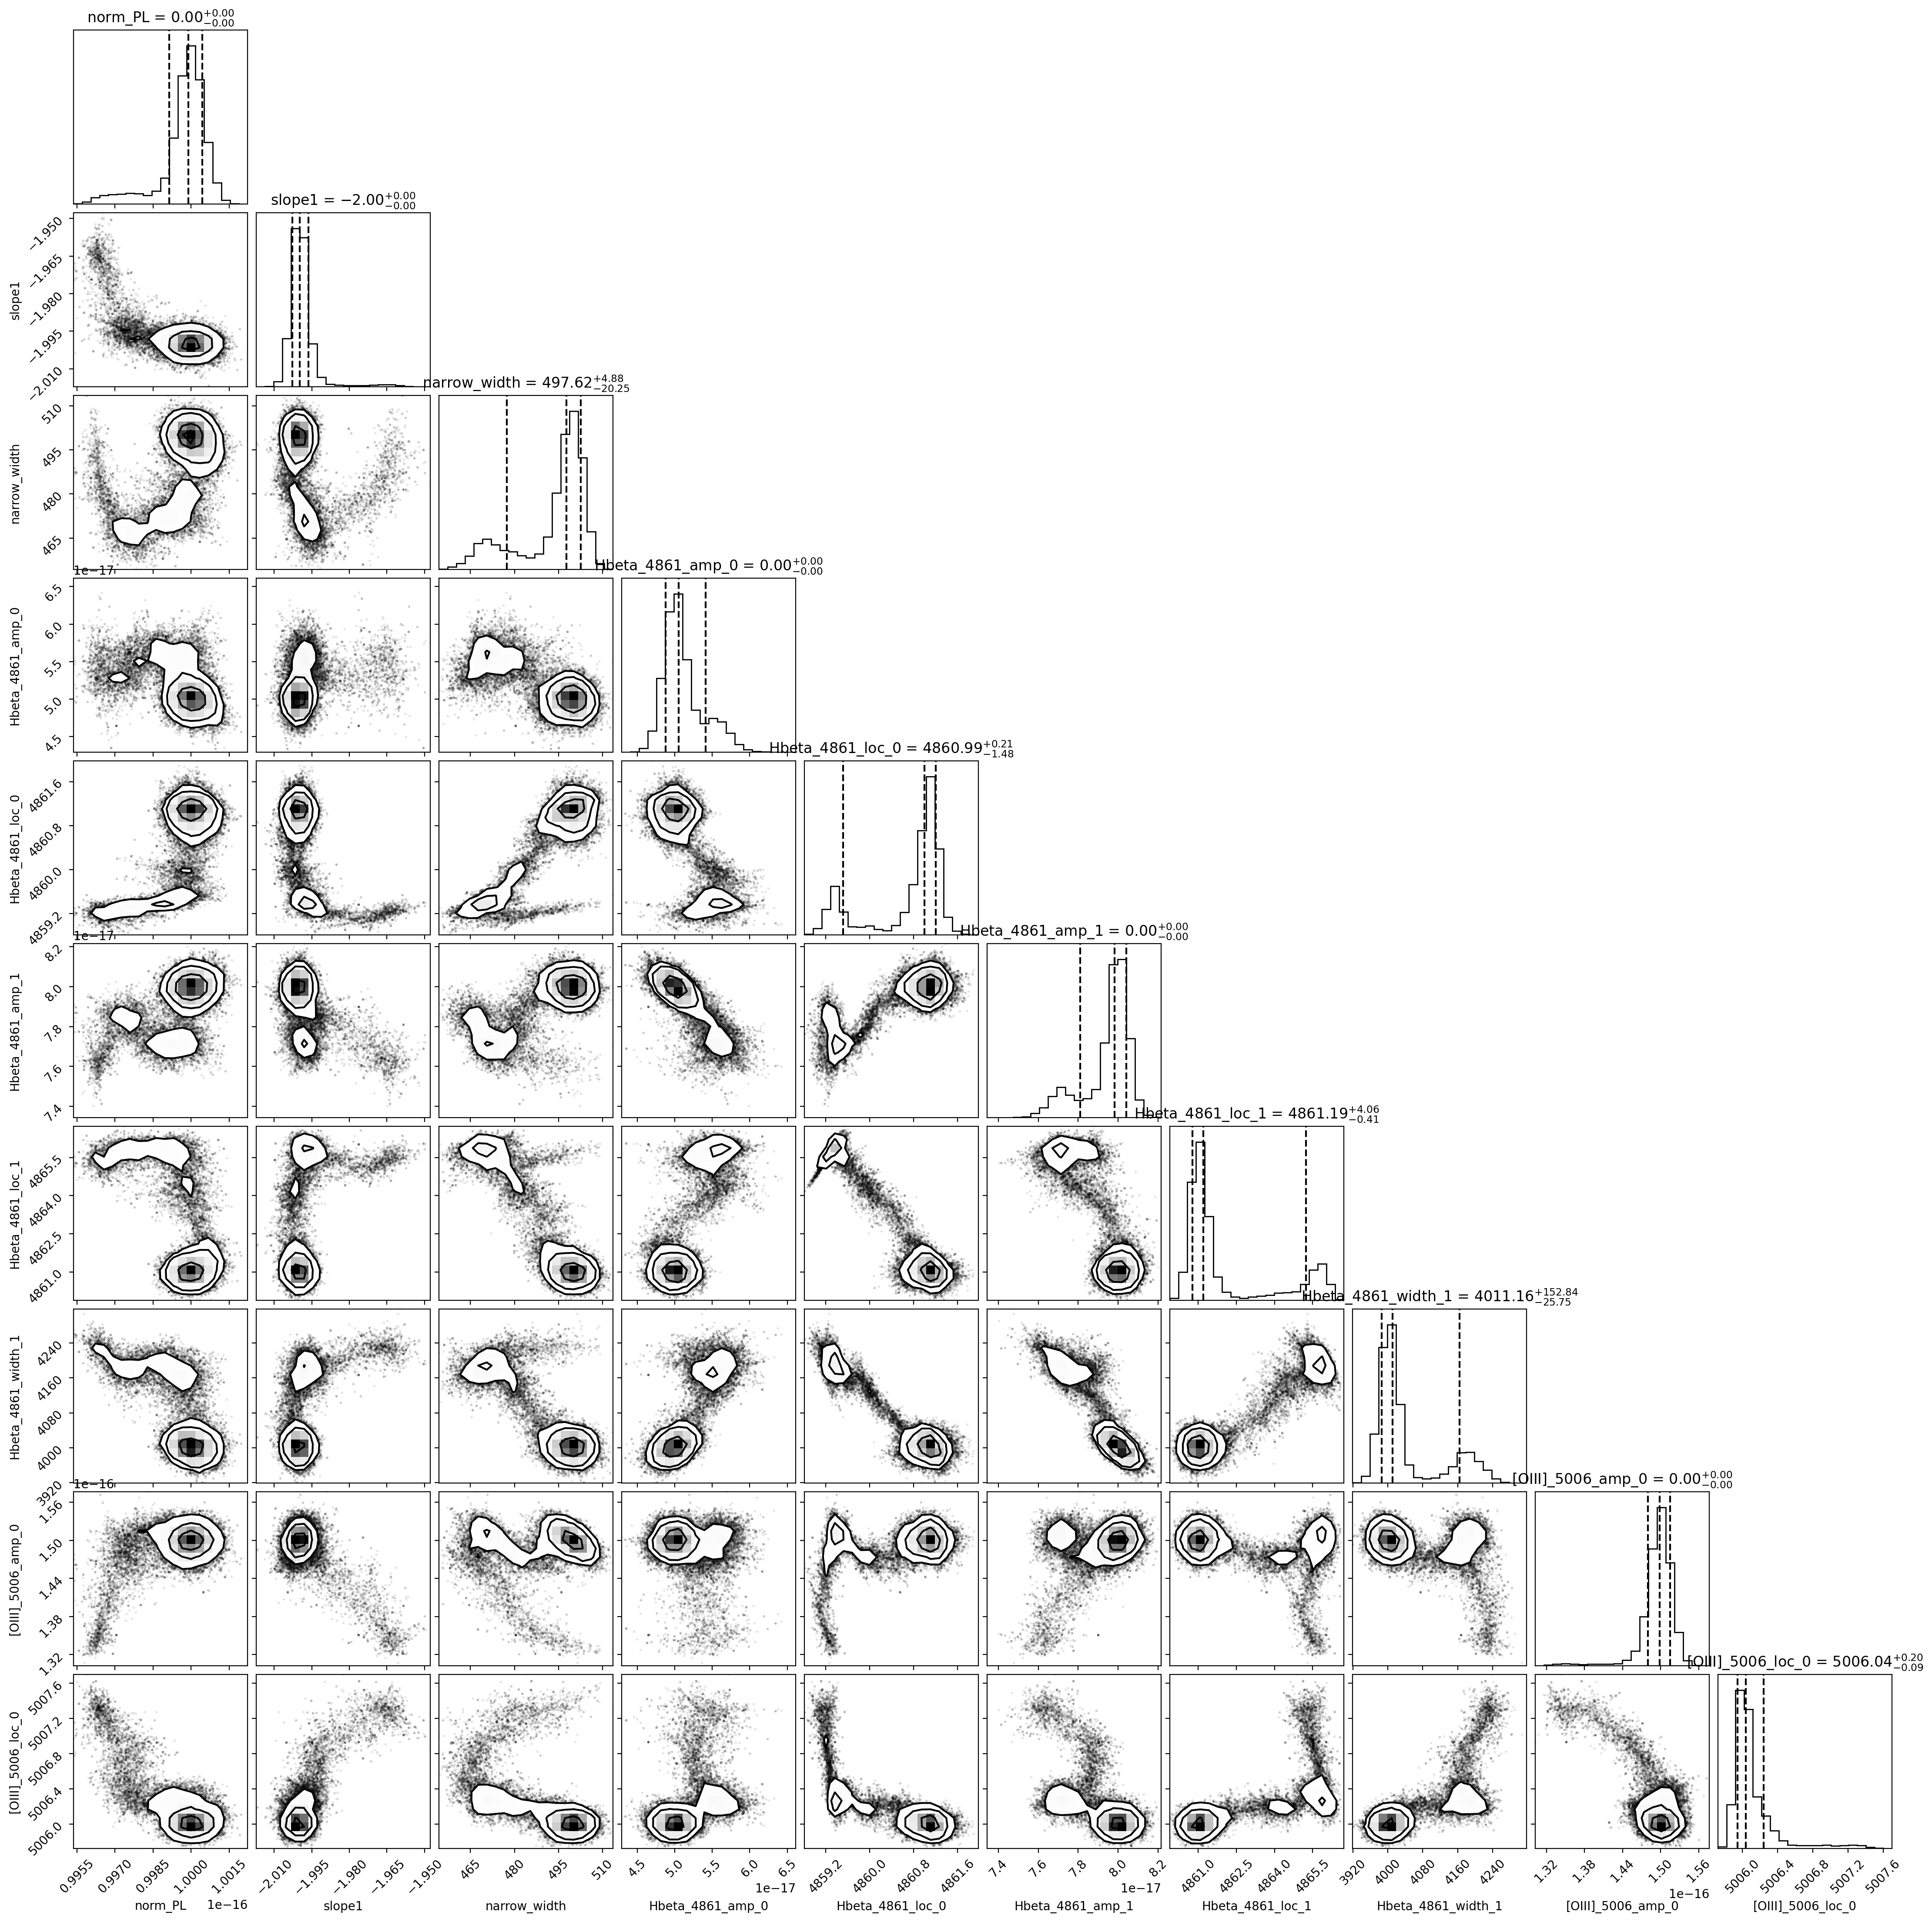

In [6]:
flat_samples = S.model.sampler.get_chain(discard=3000, thin=2, flat=True)
fig = corner.corner(flat_samples, 
                    labels=S.model_parameter_names, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True);

[ 9.99688323e-17 -1.99880720e+00  4.93165340e+02  5.11380278e-17
  4.86068125e+03  7.94501489e-17  4.86210338e+03  4.04387251e+03
  1.49498282e-16  5.00611584e+03]


In [12]:
mean_vals = np.mean(S.samples[2:], axis=0)
el_out_params = dict(zip(S.model_parameter_names[2:], mean_vals))

# Instantiate EmissionComponent
emission_component = EmissionComponent()

# Generate emission line model flux using the SPAMM engine
el_flux = emission_component.flux(mock_spectrum, el_out_params)

{'narrow_width': np.float64(9.996883878911037e-17), 'Hbeta_4861_amp_0': np.float64(-1.9988078355276888), 'Hbeta_4861_loc_0': np.float64(493.1654847102243), 'Hbeta_4861_amp_1': np.float64(5.113799904195097e-17), 'Hbeta_4861_loc_1': np.float64(4860.681277053665), 'Hbeta_4861_width_1': np.float64(7.945020751250077e-17), '[OIII]_5006_amp_0': np.float64(4862.1033177311565), '[OIII]_5006_loc_0': np.float64(4043.8688817580623)}


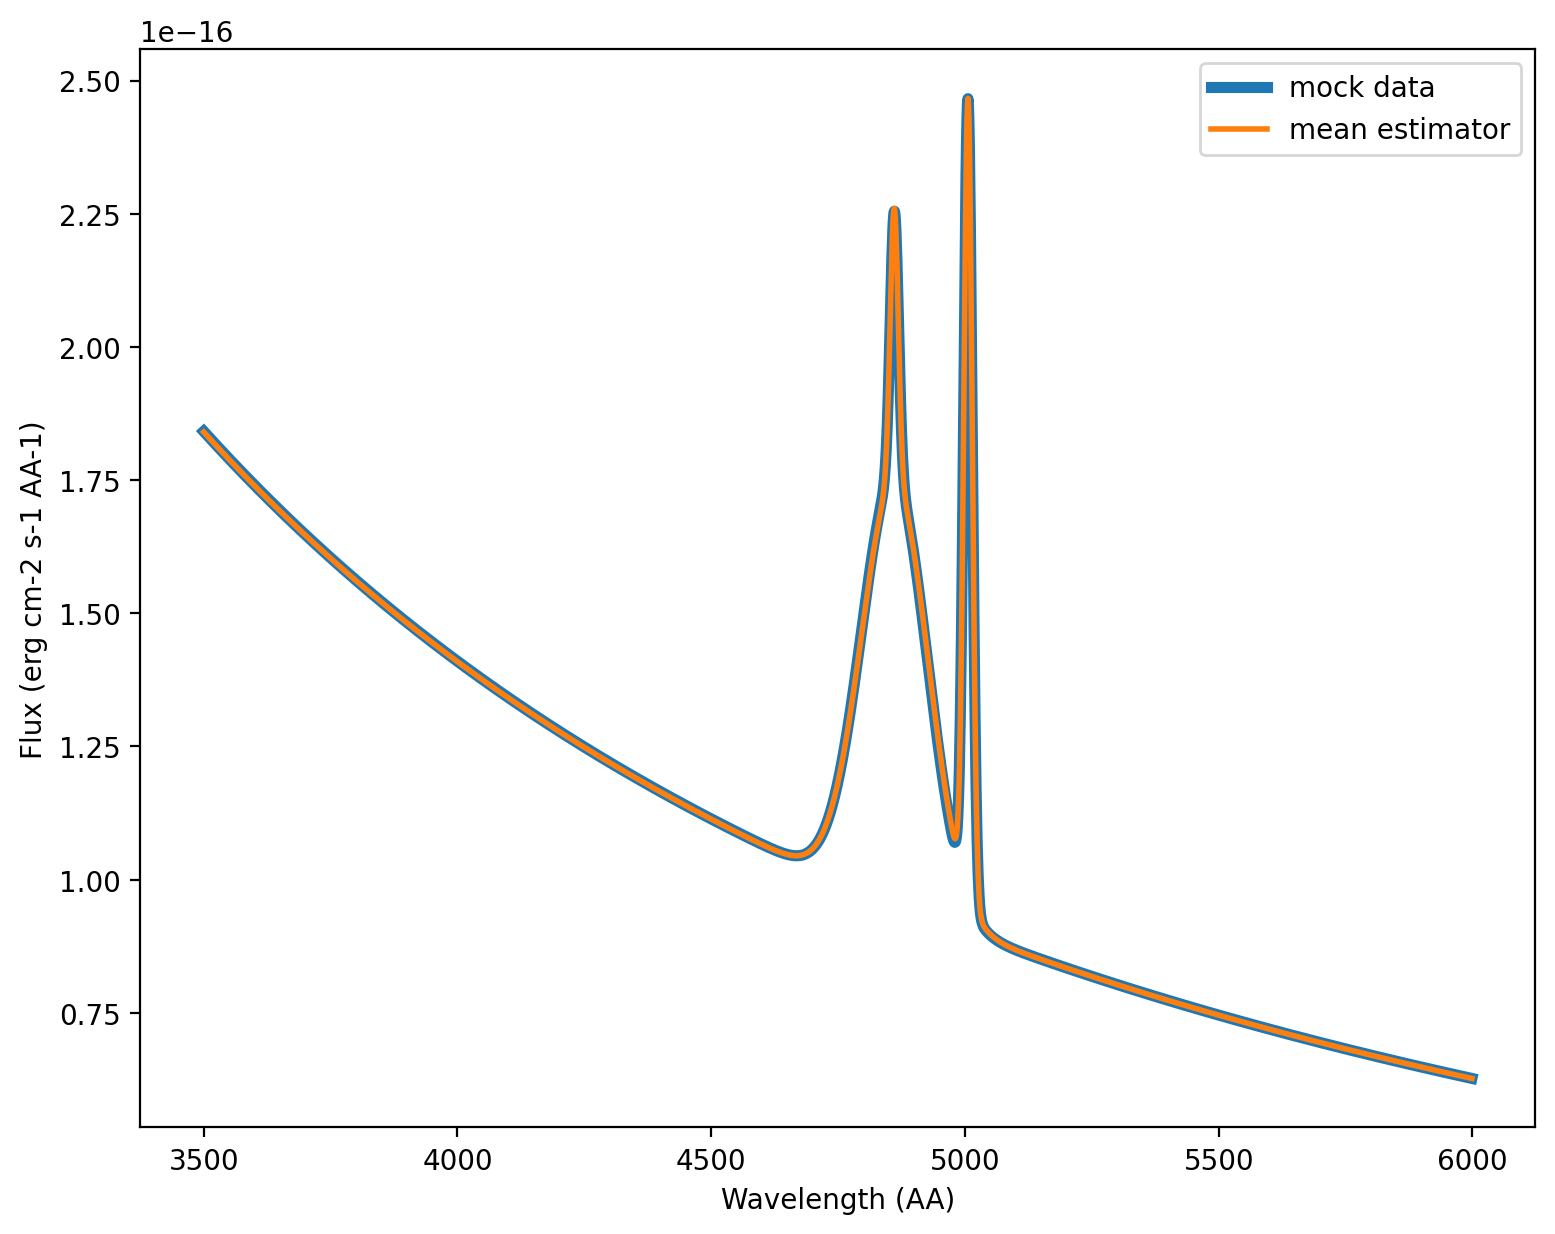

In [35]:
mean_vals = np.mean(S.samples, axis=0)
el_out_params = dict(zip(S.model_parameter_names[2:], mean_vals[2:]))

# Instantiate EmissionComponent
emission_component = EmissionComponent()
# Generate emission line model flux using the SPAMM engine
el_flux = emission_component.flux(mock_spectrum, el_out_params)

fig = plt.figure(figsize=(9,7))
mean_vals = np.mean(S.samples, axis=0)

plt.plot(wave, flux, label='mock data', lw=4)
plt.plot(wave, powerlaw(x=wave, x0=np.median(wave), amp=mean_vals[0], alpha=mean_vals[1])+el_flux, label='mean estimator', lw=2)
plt.xlabel("Wavelength (AA)")
plt.ylabel("Flux (erg cm-2 s-1 AA-1)")
plt.legend();